# Clase MLP

In [72]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Función de activación sigmoide
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Derivada de la sigmoide
def sigmoid_derivative(x):
    return x * (1 - x)

# Establece la semilla para la generación de números aleatorios
def seed(random_state=33):
    np.random.seed(random_state)

# Inicialización de javier
def xavier_initialization(input_size, output_size):
    # ¿En el parametro size es output, input?
    return np.random.normal(scale=np.sqrt(2 / (input_size + output_size)), size=(output_size, input_size))

# Inicialización normal
def normal_initialization(input_size, output_size):
    return np.random.randn(output_size, input_size) * 0.1

# Preprocesado de datos
def preprocesar(ruta):
    datos = pd.read_csv(ruta, header=0)
    datos_crudos = datos.to_numpy()

    x = datos_crudos[:, :-1]
    y = datos_crudos[:, -1:]

    return x, y

# Normalizar los datos
def normalizar_datos(X):
    scaler = StandardScaler()
    return scaler.fit_transform(X)

# Crear mini lotes
def create_minibatches(X, y, batch_size):
    """
    Genera los lotes de datos (batchs) de acuerdo al parámetro batch_size de forma aleatoria para el procesamiento. 
    """
    n_samples = X.shape[0]
    indices = np.random.permutation(n_samples)  # Mezcla los índices aleatoriamente
    X_shuffled, y_shuffled = X[indices], y[indices]  # Reordena X e y según los índices aleatorios
    
    # Divide los datos en minibatches
    for X_batch, y_batch in zip(np.array_split(X_shuffled, np.ceil(n_samples / batch_size)), 
                                np.array_split(y_shuffled, np.ceil(n_samples / batch_size))):
        yield X_batch, y_batch

# Probar modelo
def evaluar_modelo_prueba(modelo, ruta_prueba, normalizar):
    x_test_crudo, Y_test_crudo = preprocesar(ruta_prueba)

    if normalizar:
        x_test = normalizar_datos(x_test_crudo)
    else:
        x_test = x_test_crudo
    
    metricas = modelo.evaluar(x_test, Y_test_crudo)

    return metricas


class MLP_TODO:
    def __init__(self, num_entradas, num_neuronas_ocultas, num_salidas, epochs, batch_size=128, learning_rate=0.2, random_state=42, initialization="xavier"):

        # Construcción
        seed(random_state)
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        
        self.error_mse = []
        self.accuracy_epoca = []
        
        # definir las capas
        if initialization == 'xavier':
            init_fun = xavier_initialization
        else : 
            init_fun = normal_initialization

        self.W1 = init_fun(num_entradas, num_neuronas_ocultas)
        self.b1 = np.zeros((1, num_neuronas_ocultas))
        self.W2 = init_fun(num_neuronas_ocultas, num_salidas)
        self.b2 = np.zeros((1, num_salidas))

    def forward(self, X):
        #----------------------------------------------
        # 1. Propagación hacia adelante (Forward pass)
        #----------------------------------------------
        self.X = X
        self.z_c1 = X @ self.W1.T + self.b1
        self.a_c1 = sigmoid(self.z_c1)
        self.z_c2 = self.a_c1 @ self.W2.T + self.b2
        y_pred = sigmoid(self.z_c2)  # Y^
        return y_pred

    def loss_function_MSE(self, y_pred, y):
        #----------------------------------------------
        # 2. Cálculo del error con MSE
        #----------------------------------------------
        self.y_pred = y_pred
        self.y = y
        error = 0.5 * np.mean((y_pred - y) ** 2)
        return error
    
    def backward(self):
        #----------------------------------------------
        # 3. Propagación hacia atrás (Backward pass)
        #----------------------------------------------
        
        #----------------------------------------------
        # Gradiente de la salida
        #----------------------------------------------
        dE_dy_pred = (self.y_pred - self.y) / self.y.shape[0] # Derivada del error respecto a la predicción con  N ejemplos
        d_y_pred_d_zc2 = sigmoid_derivative(self.y_pred)
        delta_c2 = dE_dy_pred * d_y_pred_d_zc2

        #----------------------------------------------
        # Gradiente en la capa oculta
        #----------------------------------------------
        # calcular la derivada de las suma ponderada respecto a las activaciones de la capa 1
        delta_c1 = (delta_c2 @ self.W2) * sigmoid_derivative(self.a_c1)

        #calcula el gradiente de pesos y bias
        self.dE_dW2 = delta_c2.T @ self.a_c1
        self.dE_db2 = np.sum(delta_c2, axis=0, keepdims=True)
        self.dE_dW1 = delta_c1.T @ self.X
        self.dE_db1 = np.sum(delta_c1, axis=0, keepdims=True)

    def update(self):  # Ejecución de la actualización de paramámetros
        #----------------------------------------------
        # Actualización de pesos de la capa de salida
        #---------------------------------------------- 
        
        self.W2 = self.W2 - self.learning_rate * self.dE_dW2 # Ojito con la T
        self.b2 = self.b2 - self.learning_rate * self.dE_db2

        #----------------------------------------------
        # Actuailzación de pesos de la capa oculta
        #----------------------------------------------
        #calcula el gradiente de la función de error respecto a los pesos de la capa 1
        self.W1 = self.W1 - self.learning_rate * self.dE_dW1
        self.b1 = self.b1 - self.learning_rate * self.dE_db1

    def predict(self, X):  # Predecir la categoría para datos nuevos
        y_pred = self.forward(X)
        # Obtener la clase para el clasificador binario
        y_pred = np.where(y_pred >= 0.5, 1, 0)
        return y_pred

    def train(self, X, Y):
        for epoch in range(self.epochs):

            num_batch = 0
            epoch_error  = 0

            # Procesamiento por lotes
            for X_batch, y_batch in create_minibatches(X, Y, self.batch_size):
                y_pred = self.forward(X_batch)
                error = self.loss_function_MSE(y_pred, y_batch)
                
                # if np.all(y_pred == Y) : aciertos += 1
                # self.accuracy_epoca.append(aciertos/epoch)

                epoch_error += error
                self.backward() # cálculo de los gradientes
                self.update() # actualización de los pesos y bias
                num_batch += 1
                # Imprimir el error cada N épocas
            
            # Almacena el error promedio por época
            self.error_mse.append(epoch_error/num_batch)

            # Obtener predicciones binarias para todo el conjunto de entrenamiento
            y_pred_total = self.predict(X)

            # Calcular la exactitud
            exactitud = self.calcular_accuracy(y_pred_total, Y) 
            
            # Almacenar la exactitud de la época
            self.accuracy_epoca.append(exactitud)

            #if epoch % 100 == 0: print(f"Época {epoch:05d} | MSE: {epoch_error/num_batch:.6f} | Exactitud: {exactitud:.4f}")

    def graficar(self, graficar_exactitud=True, guardar=True, nombre="grafica"):
        """ 
        Para MSE siempre se muestra 
        """
        # Preparar datos
        mse = np.arange(len(self.error_mse))

        # Crear tabla
        plt.figure(figsize=(10,6))

        #Graficar MSE
        plt.plot(mse, self.error_mse, label="MSE", color="green", linewidth=1)


        """ 
        Para la exactitud 
        """
        if graficar_exactitud and len(self.accuracy_epoca) > 0:
            accuracy = np.arange(len(self.accuracy_epoca))
            plt.plot(accuracy, self.accuracy_epoca, label="Exactitud", color="green", linewidth=1)
            plt.ylabel("MSE / Exactitud")
            titulo = "Evolución del Error (MSE) y Exactitud durante el entrenamiento"
        else:
            plt.ylabel("Error Cuadrático Medio (MSE)")
            titulo = "Evolución del Error (MSE) durante el entrenamiento"

        plt.title(titulo)
        plt.xlabel("Época")
        plt.legend()
        plt.grid(True, alpha=0.3)

        if guardar:
            plt.savefig(f'./graficas/{nombre}.svg')
        plt.show()

    def calcular_accuracy(self, y_pred, y_verdadera):
        return np.mean(y_verdadera.flatten() == y_pred.flatten())

    def analizar(self, X, y):
        # Gráficar
        self.graficar(guardar=True, graficar_exactitud=False)

        # Valores reales y predicción
        y_pred = self.predict(X)
        print(f"valores reales: {y.flatten()}")
        print(f"Predicciones  : {y_pred.flatten()}")

        # Calcular exactitud
        exactitud = self.calcular_accuracy(y_pred, y)
        print(f"Exactitud: {exactitud}")

    def evaluar(self, x_test, y_test):
        y_gorrito = self.predict(x_test)

        accuracy = self.calcular_accuracy(y_gorrito, y_test)

        probabilidad = self.forward(x_test)
        mse = self.loss_function_MSE(probabilidad, y_test)

        metricas = {
            "Exactitud": accuracy,
            "mse": mse
        }

        return metricas

# Funciones de preprocesamiento

# Crear los modelos

In [30]:
from itertools import product
import pandas as pd
import json

# Combinaciones
hiperparametros = {
    "num_neuronas_ocultas": [2, 4, 8, 16, 32, 128],
    "inicializacion": ["xavier", "normal"],  # Distribución Normal se mapea a 'normal'
    "normalizacion_datos": [False, True], # False = Sin normalizar, True = Normalización z-score
    "learning_rate": [0.01, 0.1, 0.5],
    "batch_size": [8, 16, 32, 64],
    "dataset": ["iris_train.csv", "breast_cancer_train.csv", "wine_train.csv"]
}

# Lista con nombre de los parametros
claves = list(hiperparametros.keys()) 
valores = list(hiperparametros.values())

# Generar combinaciones como tupla
combinaciones = list(product(*valores))

# Crear una lista de diccionarios para acceder por nombre
dict_combinaciones = []
for valores_tupla in combinaciones:
    combinacion = dict(zip(claves, valores_tupla))
    dict_combinaciones.append(combinacion)

"""
Preparar datos de entrenamiento
"""

epocas = 1000
semilla = 33 
salidas = 1

# Ruta base de los datasets (basado en tu ejemplo anterior)
ruta = "./datasets/" 
resultado_data_set = {dataset: [] for dataset in hiperparametros["dataset"]}

# ¿Guardar el modelo o los parametros importantes?
resultados = []

# Entrenar

In [ ]:
for indice, parametros in enumerate(dict_combinaciones):
    # Cargar y Preprocesar el Dataset
    nombre_data_set = parametros["dataset"]
    ruta_completa = ruta + parametros['dataset']
    
    X_crudo, Y = preprocesar(ruta_completa)

    # Normalizar datos
    if parametros["normalizacion_datos"]:
        X = normalizar_datos(X_crudo)
    else:
        X = X_crudo

    # Inicializar y entrenar el modelo
    num_entradas = X.shape[1]

    modelo = MLP_TODO(
        num_entradas=num_entradas,
        num_neuronas_ocultas=parametros['num_neuronas_ocultas'],
        num_salidas=salidas,
        epochs=epocas,
        batch_size=parametros['batch_size'],
        learning_rate=parametros['learning_rate'],
        random_state=semilla,
        initialization=parametros['inicializacion']
    )
    
    modelo.train(X, Y)

    # Evaluar modelo
    nombre_prueba = parametros["dataset"].replace("_train", "_test")
    ruta_prueba = ruta + nombre_prueba
    metricas_prueba = evaluar_modelo_prueba(modelo, ruta_prueba, normalizar=parametros["normalizacion_datos"])

    # Almacenar resultados
    exactitud_final = modelo.accuracy_epoca[-1]
    mse = modelo.error_mse[-1]
    
    # Guardar en un diccionario
    resultado_data_set[nombre_data_set].append({
    "Configuracion": {k: v for k, v in parametros.items() if k != 'dataset'},
    "exactitud entrenamiento": exactitud_final,
    "mse entrenamiento": mse,
    "exactitud": metricas_prueba["Exactitud"],
    "mse": metricas_prueba["mse"]
})

# Guardar los resultados de entrenamiento

In [ ]:
# Guardar modelos en un JSON para analizar despues del entrenamiento
for nombre_dataset, resultados_lista in resultado_data_set.items():
    nombre_archivo = f"./resultados/resultados_{nombre_dataset.replace('.csv', '')}.json"

    with open(nombre_archivo, "w") as archivo:
        json.dump(resultados_lista, archivo, indent=4)

# Motrar el top 5 de cada data-set

In [ ]:
import pandas as pd

pd.set_option("display.max_colwidth", None)

archivos = ["./resultados/resultados_breast_cancer_train.json", "./resultados/resultados_iris_train.json", "./resultados/resultados_wine_train.json"]
for archivo in archivos:
    print(f"Leyendo el archivo {archivo}")
    resultado = pd.read_json(archivo)
    resultado_ordenado = (resultado.sort_values(by=['exactitud', "mse"], ascending=[False, True]))
    print(f"{resultado_ordenado.head(5)}\n\n\n")

# Gráficar la convergencia de cada modelo

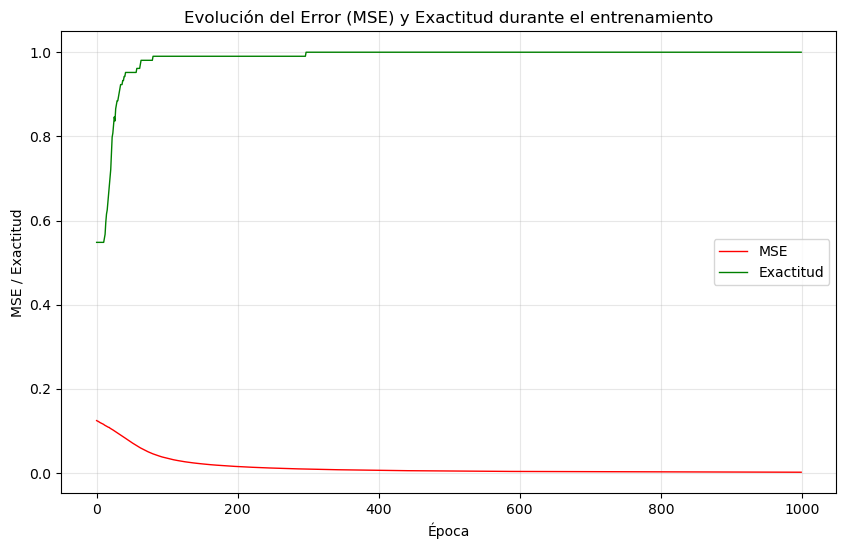

Distribución de predicciones: (array([0, 1]), array([47, 57]))
Distribución de valores reales: (array([0., 1.]), array([47, 57]))


In [ ]:
# Preparar datos
datos = ["./datasets/breast_cancer_train.csv"]

for dato in datos:
    X, Y = preprocesar(dato)

    epocas = 1000
    semilla = 33 
    entradas = X.shape[1]
    salidas = 1

    neuronas_ocultas = 32
    inicializacion = "normal"
    noramlizacion = True
    if noramlizacion: X = normalizar_datos(X)
    z_score = True
    learning_rate = 0.1
    batch_size = 32

    # Crear y entrenar
    clasificador_BC_1 = MLP_TODO(entradas, neuronas_ocultas, salidas, epochs=epocas, batch_size=batch_size, learning_rate=learning_rate, initialization=inicializacion)
    clasificador_BC_1.train(X,Y)

    # Graficar y mostrar resultados
    clasificador_BC_1.graficar(nombre="Wine 1")
    y_pred_final = clasificador_BC_1.predict(X)
    print("Distribución de predicciones:", np.unique(y_pred_final, return_counts=True))
    print("Distribución de valores reales:", np.unique(Y, return_counts=True))



=== PROCESANDO BREAST_CANCER ===
Entrenando modelo 1 para breast_cancer...
  - Exactitud final: 0.9890
  - Config: {'num_neuronas_ocultas': 8, 'inicializacion': 'xavier', 'normalizacion_datos': True, 'learning_rate': 0.1, 'batch_size': 64}
Entrenando modelo 2 para breast_cancer...
  - Exactitud final: 0.9890
  - Config: {'num_neuronas_ocultas': 16, 'inicializacion': 'xavier', 'normalizacion_datos': True, 'learning_rate': 0.1, 'batch_size': 64}
Entrenando modelo 3 para breast_cancer...
  - Exactitud final: 0.9890
  - Config: {'num_neuronas_ocultas': 32, 'inicializacion': 'xavier', 'normalizacion_datos': True, 'learning_rate': 0.1, 'batch_size': 64}
Entrenando modelo 4 para breast_cancer...
  - Exactitud final: 0.9890
  - Config: {'num_neuronas_ocultas': 16, 'inicializacion': 'normal', 'normalizacion_datos': True, 'learning_rate': 0.1, 'batch_size': 64}
Entrenando modelo 5 para breast_cancer...
  - Exactitud final: 0.9890
  - Config: {'num_neuronas_ocultas': 8, 'inicializacion': 'normal

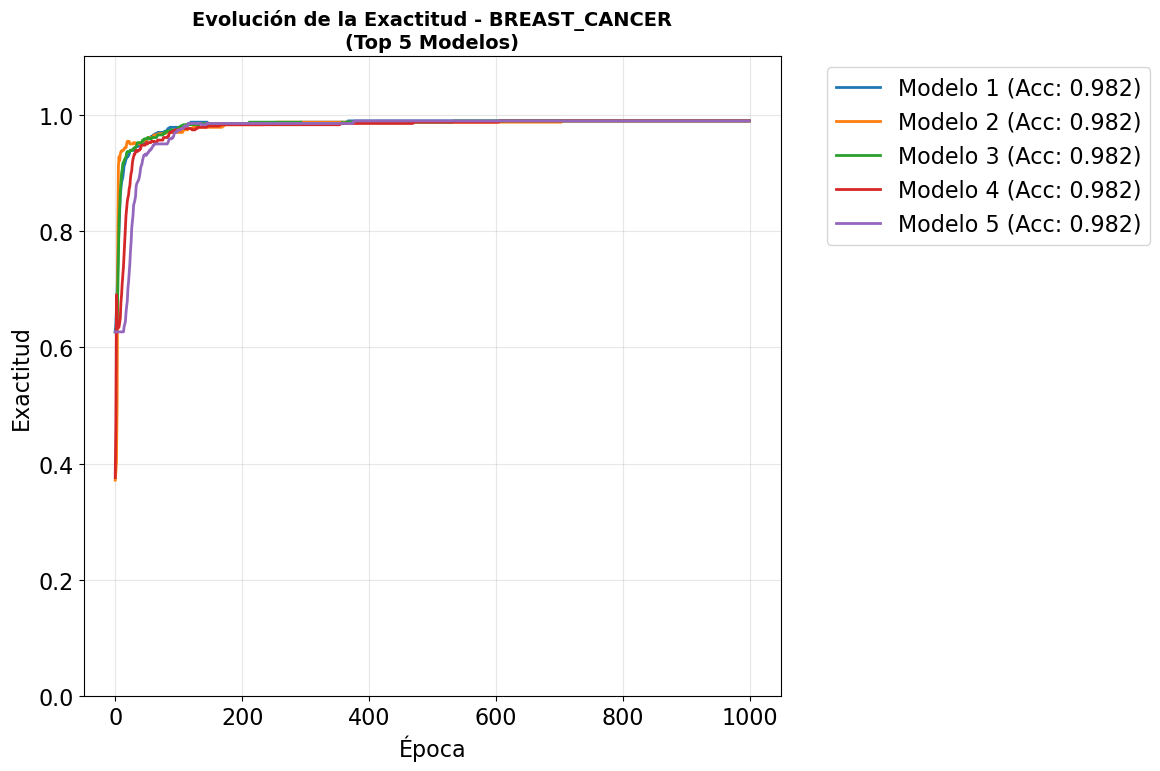

Gráfica guardada para breast_cancer

=== PROCESANDO IRIS ===
Entrenando modelo 1 para iris...
  - Exactitud final: 1.0000
  - Config: {'num_neuronas_ocultas': 128, 'inicializacion': 'xavier', 'normalizacion_datos': False, 'learning_rate': 0.5, 'batch_size': 8}
Entrenando modelo 2 para iris...
  - Exactitud final: 1.0000
  - Config: {'num_neuronas_ocultas': 128, 'inicializacion': 'normal', 'normalizacion_datos': False, 'learning_rate': 0.5, 'batch_size': 8}
Entrenando modelo 3 para iris...
  - Exactitud final: 1.0000
  - Config: {'num_neuronas_ocultas': 32, 'inicializacion': 'normal', 'normalizacion_datos': False, 'learning_rate': 0.5, 'batch_size': 8}
Entrenando modelo 4 para iris...
  - Exactitud final: 1.0000
  - Config: {'num_neuronas_ocultas': 32, 'inicializacion': 'xavier', 'normalizacion_datos': False, 'learning_rate': 0.5, 'batch_size': 8}
Entrenando modelo 5 para iris...
  - Exactitud final: 1.0000
  - Config: {'num_neuronas_ocultas': 16, 'inicializacion': 'normal', 'normalizac

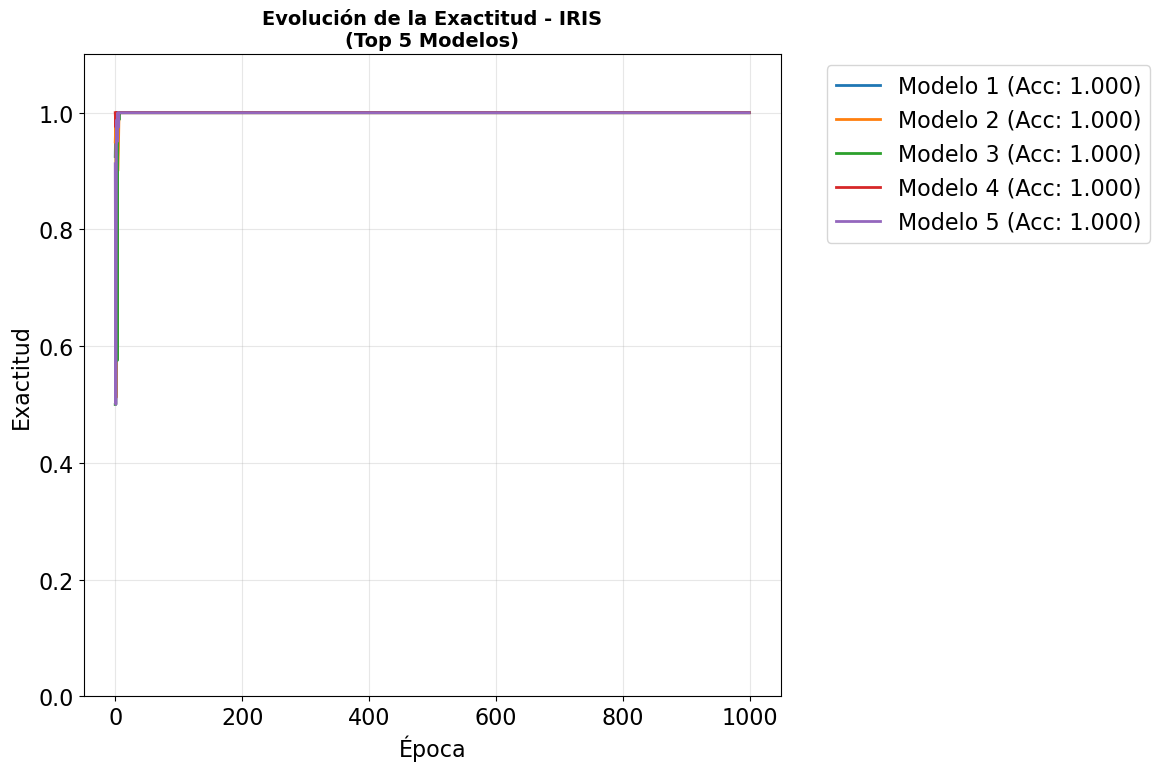

Gráfica guardada para iris

=== PROCESANDO WINE ===
Entrenando modelo 1 para wine...
  - Exactitud final: 1.0000
  - Config: {'num_neuronas_ocultas': 32, 'inicializacion': 'normal', 'normalizacion_datos': True, 'learning_rate': 0.1, 'batch_size': 32}
Entrenando modelo 2 para wine...
  - Exactitud final: 1.0000
  - Config: {'num_neuronas_ocultas': 32, 'inicializacion': 'xavier', 'normalizacion_datos': True, 'learning_rate': 0.1, 'batch_size': 32}
Entrenando modelo 3 para wine...
  - Exactitud final: 1.0000
  - Config: {'num_neuronas_ocultas': 16, 'inicializacion': 'normal', 'normalizacion_datos': True, 'learning_rate': 0.1, 'batch_size': 32}
Entrenando modelo 4 para wine...
  - Exactitud final: 1.0000
  - Config: {'num_neuronas_ocultas': 32, 'inicializacion': 'normal', 'normalizacion_datos': True, 'learning_rate': 0.1, 'batch_size': 16}
Entrenando modelo 5 para wine...
  - Exactitud final: 1.0000
  - Config: {'num_neuronas_ocultas': 32, 'inicializacion': 'xavier', 'normalizacion_datos':

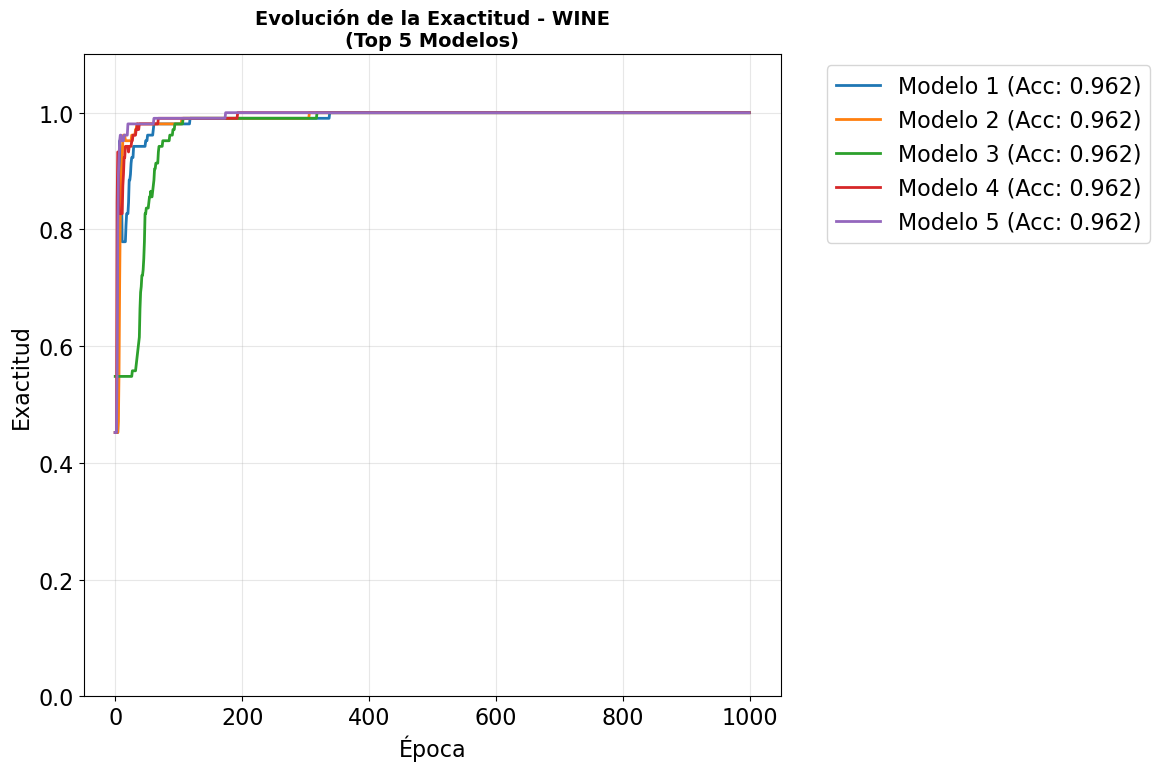

Gráfica guardada para wine


In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np

def cargar_y_entrenar_mejores_modelos():
    archivos = {
        "breast_cancer": "./resultados/resultados_breast_cancer_train.json",
        "iris": "./resultados/resultados_iris_train.json", 
        "wine": "./resultados/resultados_wine_train.json"
    }
    
    # Configuración común
    epocas = 1000
    semilla = 33
    salidas = 1
    ruta_base = "./datasets/"
    
    for nombre_dataset, archivo_resultados in archivos.items():
        print(f"\n=== PROCESANDO {nombre_dataset.upper()} ===")
        
        # Cargar resultados
        with open(archivo_resultados, 'r') as f:
            resultados = json.load(f)
        
        # Ordenar y tomar los 5 mejores por exactitud en prueba
        resultados_ordenados = sorted(resultados, 
                                    key=lambda x: (x['exactitud'], -x['mse']), 
                                    reverse=True)[:5]
        
        plt.figure(figsize=(12, 8))
        
        for i, resultado in enumerate(resultados_ordenados):
            config = resultado['Configuracion']
            
            # Cargar y preparar datos
            nombre_archivo_train = f"{nombre_dataset}_train.csv"
            ruta_completa = ruta_base + nombre_archivo_train
            X_crudo, Y = preprocesar(ruta_completa)
            
            # Normalizar si corresponde
            if config['normalizacion_datos']:
                X = normalizar_datos(X_crudo)
            else:
                X = X_crudo
            
            # Crear y entrenar modelo
            modelo = MLP_TODO(
                num_entradas=X.shape[1],
                num_neuronas_ocultas=config['num_neuronas_ocultas'],
                num_salidas=salidas,
                epochs=epocas,
                batch_size=config['batch_size'],
                learning_rate=config['learning_rate'],
                random_state=semilla,
                initialization=config['inicializacion']
            )
            
            print(f"Entrenando modelo {i+1} para {nombre_dataset}...")
            modelo.train(X, Y)
            
            # Graficar en la misma figura
            epochs_range = range(len(modelo.accuracy_epoca))
            plt.plot(epochs_range, modelo.accuracy_epoca, 
                    label=f"Modelo {i+1} (Acc: {resultado['exactitud']:.3f})",
                    linewidth=2)
            
            print(f"  - Exactitud final: {modelo.accuracy_epoca[-1]:.4f}")
            print(f"  - Config: {config}")
        
        # Personalizar gráfica
        plt.title(f'Evolución de la Exactitud - {nombre_dataset.upper()}\n(Top 5 Modelos)', 
                 fontsize=14, fontweight='bold')
        plt.xlabel('Época')
        plt.ylabel('Exactitud')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.ylim(0, 1.1)
        
        # Ajustar layout y guardar
        plt.tight_layout()
        plt.savefig(f'./graficas/comparacion_top5_{nombre_dataset}.png', 
                   dpi=300, bbox_inches='tight')
        plt.savefig(f'./graficas/comparacion_top5_{nombre_dataset}.svg', 
                   bbox_inches='tight')
        plt.show()
        
        print(f"Gráfica guardada para {nombre_dataset}")

# Ejecutar la función
cargar_y_entrenar_mejores_modelos()